In [152]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, Dataset, DataLoader
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"

In [153]:
class CustomImageFolderDataset(Dataset):
    def __init__(self, *paths):
        self.datasets = [datasets.ImageFolder(root=path) for path in paths]
        
        all_classes = sorted(set(cls for ds in self.datasets for cls in ds.classes))
        
        self.class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}
        self.classes = all_classes
        
        self.imgs = []
        for ds in self.datasets:
            for img_path, target in ds.imgs:
                new_target = self.class_to_idx[ds.classes[target]]
                self.imgs.append((img_path, new_target))
        
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = Image.open(path).convert('RGB')  
        return img, target

    def __len__(self):
        return len(self.imgs)

In [154]:
data_dir1 = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0'
data_dir2 = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1'
data_dir3 = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2'


custom_dataset = CustomImageFolderDataset(data_dir1, data_dir2, data_dir3)

In [155]:
custom_dataset.class_to_idx

{'all': 0, 'hem': 1}

In [156]:
custom_dataset.classes

['all', 'hem']

In [157]:
custom_dataset.imgs[0]

('/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all/UID_11_10_1_all.bmp',
 0)

In [158]:
custom_dataset[0]

(<PIL.Image.Image image mode=RGB size=450x450>, 0)

In [159]:
len(custom_dataset)

10661

In [160]:
from torch.utils.data import random_split

train_ratio = 0.8

# Розділіть набір даних
train_data, val_data = random_split(custom_dataset, [train_ratio, 1-train_ratio])

In [161]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.RandomHorizontalFlip(p=0.5), # Випадково перевернути по горизонталі з ймовірністю 50%
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
    transforms.Normalize(mean=[0.0454, 0.0197, 0.0518],
                         std=[0.1014, 0.0452, 0.1154]), # нормалізація для моделей
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
    transforms.Normalize(mean=[0.0454, 0.0197, 0.0518],
                         std=[0.1014, 0.0452, 0.1154]), # нормалізація для моделей
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
train_data = TransformDataset(train_data, transform = train_transform)
val_data = TransformDataset(val_data, transform = test_transform)

In [162]:
means = []
stds = []
for img, _ in val_data:
    means.append(torch.mean(img, [1, 2]).tolist())
    stds.append(torch.std(img, [1, 2]).tolist())

mean = torch.mean(torch.tensor(means), [0])
std = torch.mean(torch.tensor(stds), [0])

mean, std

(tensor([-0.0024, -0.0017, -0.0007]), tensor([0.9951, 0.9958, 0.9985]))

In [163]:
len(train_data), len(val_data)

(8529, 2132)

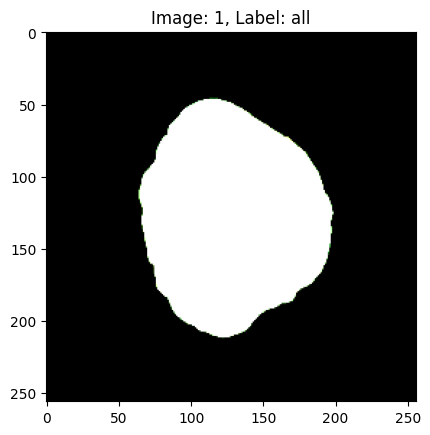

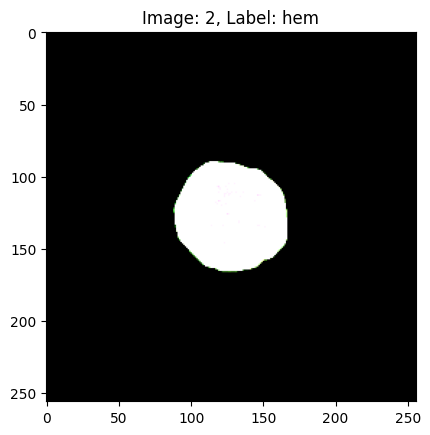

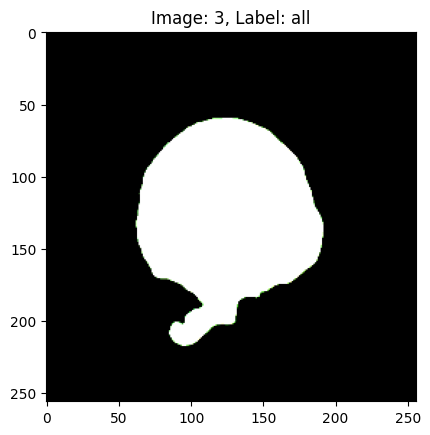

In [164]:
import matplotlib.pyplot as plt

for i in range(3):  # Show 3 images
    img, label = train_data[i]

    # Get the image data (tensor) and convert it back to a NumPy array for manipulation
    img = img.numpy()

    # Convert the color channels from (channels, height, width) to (height, width, channels) for pyplot
    img = img.transpose((1, 2, 0))

    # Get the label name from the dataset class labels
    label_name = custom_dataset.classes[label]

    # Plot the image with a title (including label name)
    plt.imshow(img)
    plt.title(f"Image: {i+1}, Label: {label_name}")
    plt.show()

In [165]:
batch_size = 32

# Створіть завантажувачі даних
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)

In [166]:
from torchvision import models

resnet = models.resnet152(pretrained=True)
resnet

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [167]:
from torch import nn
import torch.nn.functional as F
import numpy as np


class TransferLearningClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        resnet = models.resnet152(pretrained=True)
        
        # від'єднання градієнтів
        for param in resnet.parameters():
            param.requires_grad = False
        
        # кількість нейронів на виході
        in_features = resnet.fc.in_features
        
        # деактивація останнього шару
        resnet.fc = nn.Identity()
        
        # створення потрібних шарів
        self.feature_extractor = resnet
        
        #self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        out = self.feature_extractor(x) # (batch, in_features)
        
        #out = self.dropout(out)
        out = self.linear(out)
        
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()


model = TransferLearningClassifier(len(custom_dataset.classes)).to(device)

In [168]:
!pip install -q torchsummary

In [169]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [170]:
# Визначення функції втрат та оптимізатора

loss_fn = nn.CrossEntropyLoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [171]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass
    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}
        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)
        
        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)
            
        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history


In [172]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=TransferLearningClassifier, opt=Adam(lr=0.000100), epochs=10, device=cuda

Epoch    1  134sec	loss:       0.52	val_loss:      0.452	accuracy_score:      0.758	val_accuracy_score:      0.821	
Epoch    2  135sec	loss:      0.442	val_loss:      0.421	accuracy_score:      0.817	val_accuracy_score:      0.836	
Epoch    3  136sec	loss:      0.418	val_loss:      0.409	accuracy_score:       0.83	val_accuracy_score:      0.841	
Epoch    4  136sec	loss:      0.412	val_loss:        0.4	accuracy_score:       0.83	val_accuracy_score:      0.844	
Epoch    5  136sec	loss:        0.4	val_loss:      0.415	accuracy_score:      0.838	val_accuracy_score:      0.826	
Epoch    6  136sec	loss:      0.395	val_loss:       0.39	accuracy_score:      0.839	val_accuracy_score:      0.846	
Epoch    7  136sec	loss:      0.388	val_loss:      0.387	accuracy_score:      0.841	val_accuracy_score:      0.845	
Epoch    8  137sec	loss:      0.385	val_loss:      0.381	accuracy_score:      0.846	val_acc

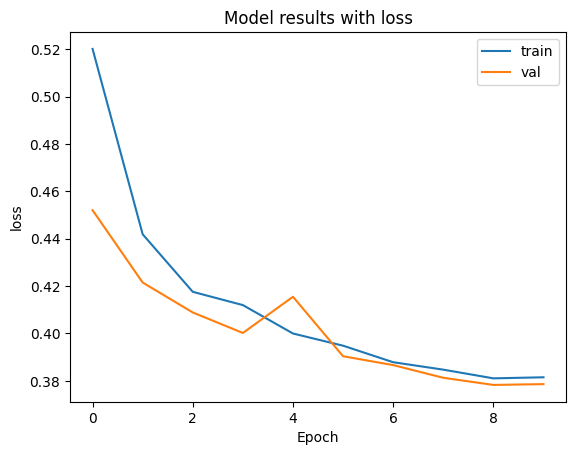

In [173]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

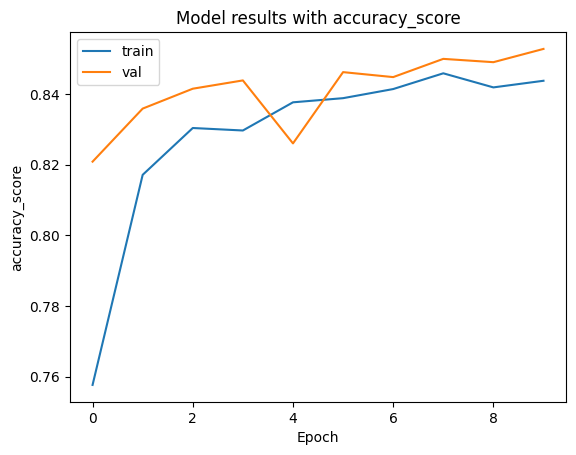

In [174]:
plot_metric(history, 'accuracy_score')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')  # відключаємо від gpu

loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=custom_dataset.classes)
plt.xticks(rotation=90)
plt.plot()